Импорт необходимых библиотек

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets

Установка нормализующих преобразований, загрузка набора
данных (MNIST), разделение данных на подвыборки

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 85393865.39it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 85366944.20it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30196311.40it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5964473.63it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Настройка использования графического ускорителя

In [ ]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

Создание класса НС на основе фреймворка torch

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout(0.25)
    self.dropout2 = nn.Dropout(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

Проверка работоспособности созданного класса НС

In [ ]:
model = Net().to(device)

Создание оптимизатора, функции потерь и трейнер сети

In [ ]:
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

Определение функции обучения сети

In [ ]:
def fit(model,device,train_loader,val_loader,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

Обучение модели

In [ ]:
loss,val_loss=fit(model,device,train_loader,val_loader,10)

Fitting the model...
Epoch: 1 Loss: 0.24706882475398342 Val_Loss: 0.11875709806607274
Epoch: 2 Loss: 0.09778136674620828 Val_Loss: 0.09214799385188453
Epoch: 3 Loss: 0.07779520080464969 Val_Loss: 0.0783715507894399
Epoch: 4 Loss: 0.06755321083668932 Val_Loss: 0.07584702005366886
Epoch: 5 Loss: 0.061873877610346274 Val_Loss: 0.07461488201667736
Epoch: 6 Loss: 0.05636024495540833 Val_Loss: 0.07476075996830749
Epoch: 7 Loss: 0.056502587110686675 Val_Loss: 0.07840224256516078
Epoch: 8 Loss: 0.05126775824896975 Val_Loss: 0.06912599970659543
Epoch: 9 Loss: 0.05093053947893996 Val_Loss: 0.06976715040090288
Epoch: 10 Loss: 0.050203166993184965 Val_Loss: 0.07717142459465097


Пострение графиков потерь при обучении и валидации в зависимости от эпохи

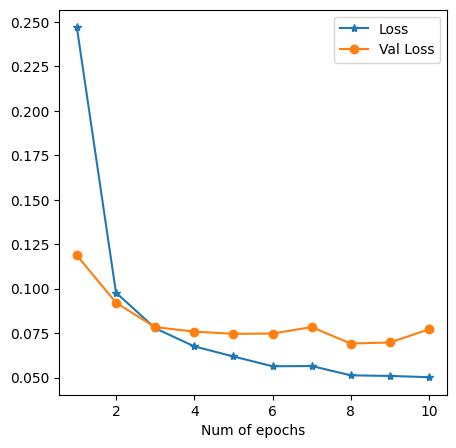

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11), loss, "*-",label="Loss")
plt.plot(np.arange(1,11), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

Создание функции атак FGSM, I-FGSM, MI-FGSM

In [ ]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

In [ ]:
def ifgsm_attack(input,epsilon,data_grad):
 iter = 10
 alpha = epsilon/iter
 pert_out = input
 for i in range(iter-1):
  pert_out = pert_out + alpha*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  if torch.norm((pert_out-input),p=float('inf')) > epsilon:
    break
 return pert_out

In [ ]:
def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

Создание функции проверки

In [ ]:
def test(model,device,test_loader,epsilon,attack):
  correct = 0
  adv_examples = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != target.item():
      continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)
    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
      correct += 1
    if (epsilon == 0) and (len(adv_examples) < 5):
      adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
      adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex))
    else:
      if len(adv_examples) < 5:
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex))
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct,  len(test_loader), final_acc))
  return final_acc, adv_examples

Построение графиков успешности атак(Accuracy/эпсилон)
и примеры выполненных атак в зависимости от степени
возмущения epsilon

Epsilon: 0	Test Accuracy = 9734 / 10000 = 0.9734
Epsilon: 0.007	Test Accuracy = 9729 / 10000 = 0.9729
Epsilon: 0.01	Test Accuracy = 9710 / 10000 = 0.971
Epsilon: 0.02	Test Accuracy = 9664 / 10000 = 0.9664
Epsilon: 0.03	Test Accuracy = 9607 / 10000 = 0.9607
Epsilon: 0.05	Test Accuracy = 9430 / 10000 = 0.943
Epsilon: 0.1	Test Accuracy = 8672 / 10000 = 0.8672
Epsilon: 0.2	Test Accuracy = 5430 / 10000 = 0.543
Epsilon: 0.3	Test Accuracy = 2143 / 10000 = 0.2143


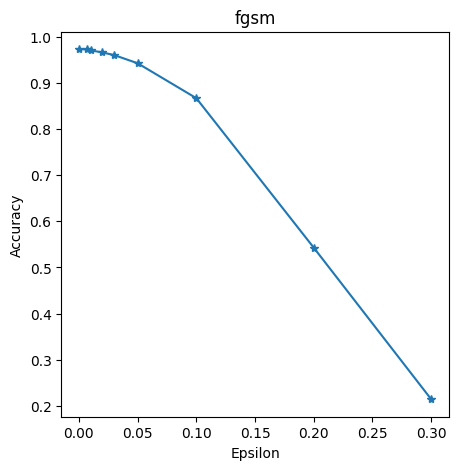

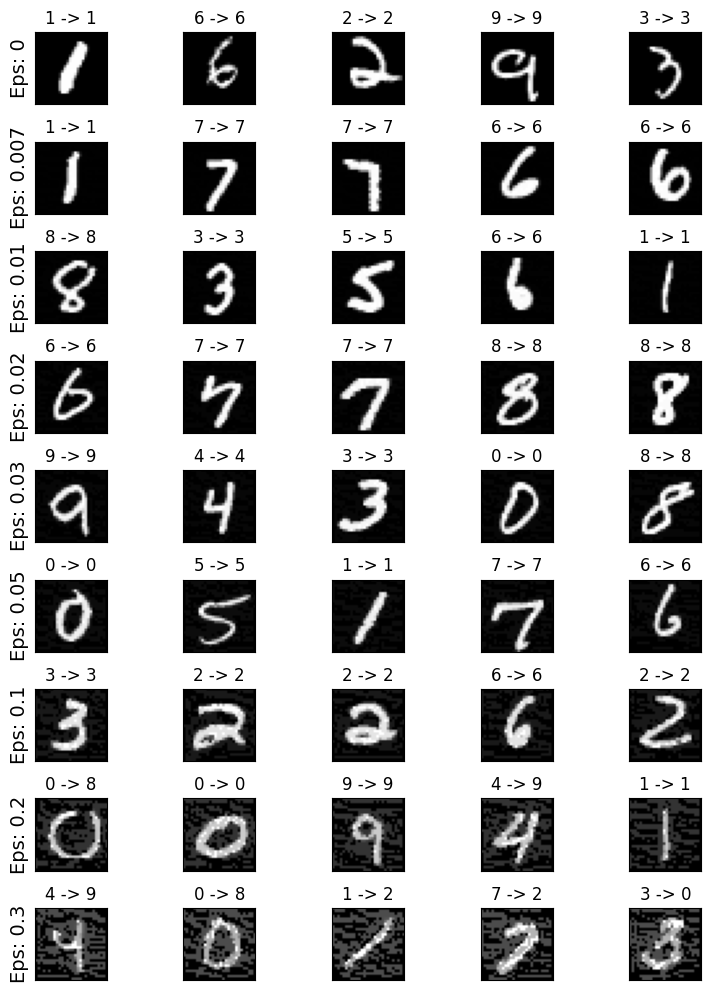

Epsilon: 0	Test Accuracy = 9725 / 10000 = 0.9725
Epsilon: 0.007	Test Accuracy = 9725 / 10000 = 0.9725
Epsilon: 0.01	Test Accuracy = 9700 / 10000 = 0.97
Epsilon: 0.02	Test Accuracy = 9665 / 10000 = 0.9665
Epsilon: 0.03	Test Accuracy = 9587 / 10000 = 0.9587
Epsilon: 0.05	Test Accuracy = 9461 / 10000 = 0.9461
Epsilon: 0.1	Test Accuracy = 8874 / 10000 = 0.8874
Epsilon: 0.2	Test Accuracy = 6220 / 10000 = 0.622
Epsilon: 0.3	Test Accuracy = 2918 / 10000 = 0.2918


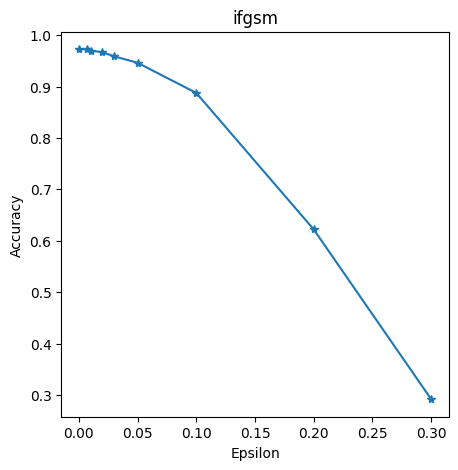

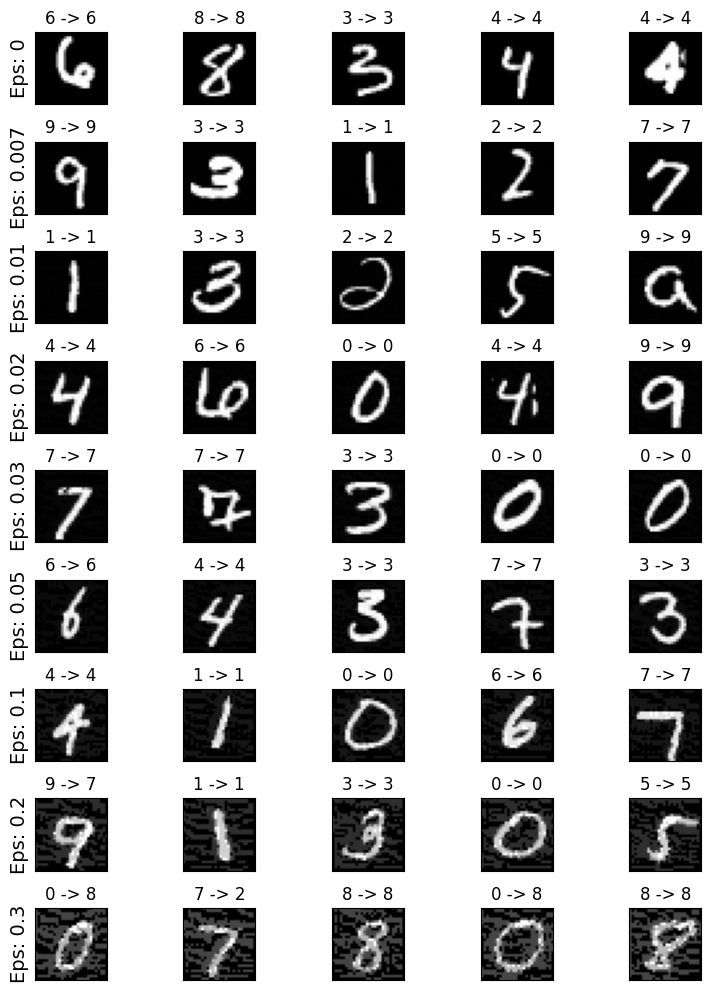

Epsilon: 0	Test Accuracy = 9766 / 10000 = 0.9766
Epsilon: 0.007	Test Accuracy = 9713 / 10000 = 0.9713
Epsilon: 0.01	Test Accuracy = 9710 / 10000 = 0.971
Epsilon: 0.02	Test Accuracy = 9658 / 10000 = 0.9658
Epsilon: 0.03	Test Accuracy = 9601 / 10000 = 0.9601
Epsilon: 0.05	Test Accuracy = 9470 / 10000 = 0.947
Epsilon: 0.1	Test Accuracy = 8840 / 10000 = 0.884
Epsilon: 0.2	Test Accuracy = 6237 / 10000 = 0.6237
Epsilon: 0.3	Test Accuracy = 2898 / 10000 = 0.2898


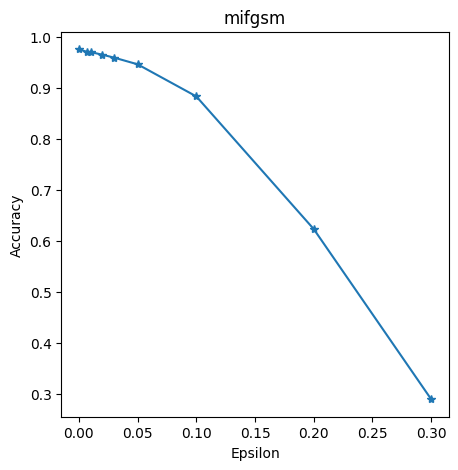

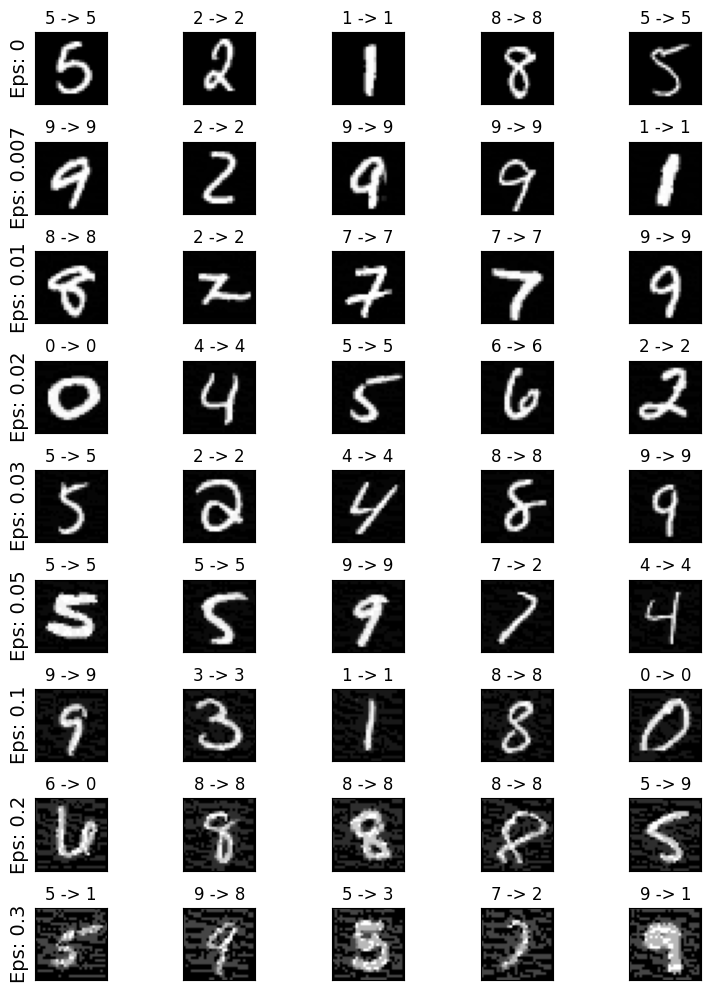

In [ ]:
epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
for attack in ("fgsm","ifgsm","mifgsm"):
  accuracies = []
  examples = []
  for eps in epsilons:
    acc, ex = test(model, device,test_loader,eps,attack)
    accuracies.append(acc)
    examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()
  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
    for j in range(len(examples[i])):
      cnt += 1
      plt.subplot(len(epsilons),len(examples[0]),cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if j == 0:
        plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
      orig,adv,ex = examples[i][j]
      plt.title("{} -> {}".format(orig, adv))
      plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

Создание 2 классов НС

In [ ]:
class NetF(nn.Module):
  def __init__(self):
    super(NetF, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

In [ ]:
class NetF1(nn.Module):
  def __init__(self):
    super(NetF1, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(4608, 64)
    self.fc2 = nn.Linear(64, 10)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

Переопределение функции обучения и тестирования

In [ ]:
def fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label = data[0].to(device),data[1].to(device)
        output = model(input)
        output = F.log_softmax(output/Temp,dim=1)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
      else:
        val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss
def test(model,device,test_loader,epsilon,Temp,attack):
  correct=0
  adv_examples = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    output = F.log_softmax(output/Temp,dim=1)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != target.item():
      continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)
    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
      correct += 1
    if (epsilon == 0) and (len(adv_examples) < 5):
      adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
      adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    else:
      if len(adv_examples) < 5:
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return final_acc,adv_examples

Создание функции защиты методом дистилляции

In [ ]:
def defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons):
  modelF = NetF().to(device)
  optimizerF = optim.Adam(modelF.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)
  modelF1 = NetF1().to(device)
  optimizerF1 = optim.Adam(modelF1.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)
  criterion = nn.NLLLoss()
  lossF,val_lossF=fit(modelF,device,optimizerF,schedulerF,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
  plt.title("Network F")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()
  #converting target labels to soft labels
  for data in train_loader:
    input, label = data[0].to(device),data[1].to(device)
    softlabel = F.log_softmax(modelF(input),dim=1)
    data[1] = softlabel
  lossF1,val_lossF1=fit(modelF1,device,optimizerF1,schedulerF1,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
  plt.title("Network F'")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()
  model = NetF1().to(device)
  model.load_state_dict(modelF1.state_dict())
  for attack in ("fgsm","ifgsm","mifgsm"):
    accuracies = []
    examples = []
    for eps in epsilons:
      acc, ex = test(model,device,test_loader,eps,1,"fgsm")
      accuracies.append(acc)
      examples.append(ex)
    plt.figure(figsize=(5,5))
    plt.plot(epsilons, accuracies, "*-")
    plt.title(attack)
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()
    cnt = 0
    plt.figure(figsize=(8,10))
    for i in range(len(epsilons)):
      for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
          plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()


Получение результатов оценки защищенных сетей

Fitting the model...


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1 Loss: 0.5375189128678622 Val_Loss: 6.969383265823126e-05
Epoch: 2 Loss: 0.32486814951581344 Val_Loss: 2.186994447838515e-05
Epoch: 3 Loss: 0.2556781296674071 Val_Loss: 1.6314317283695346e-05
Epoch: 4 Loss: 0.19516627287654367 Val_Loss: 1.2731560622341932e-06
Epoch: 5 Loss: 0.15980673959424674 Val_Loss: 3.417146508581936e-08
Epoch: 6 Loss: 0.13200890548509517 Val_Loss: 3.658524006823427e-07
Epoch: 7 Loss: 0.1118753171143204 Val_Loss: 1.4799942382524022e-07
Epoch: 8 Loss: 0.1041424016673084 Val_Loss: 3.248991561122239e-07
Epoch: 9 Loss: 0.09686187430703556 Val_Loss: 3.751271403416467e-07
Epoch: 10 Loss: 0.0827595821387276 Val_Loss: 3.592985171126202e-05


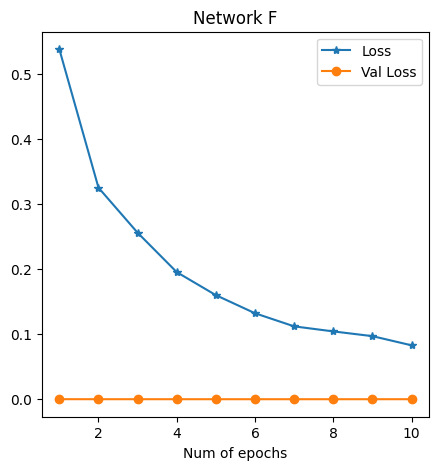

Fitting the model...
Epoch: 1 Loss: 0.6809084704135504 Val_Loss: 0.00012572760730981828
Epoch: 2 Loss: 0.454891653067648 Val_Loss: 9.95219288393855e-05
Epoch: 3 Loss: 0.3873085003449309 Val_Loss: 0.0001938994871918112
Epoch: 4 Loss: 0.3214666975884713 Val_Loss: 1.948836026713252e-07
Epoch: 5 Loss: 0.25826870979275546 Val_Loss: 6.778743117092745e-06
Epoch: 6 Loss: 0.2228698142529629 Val_Loss: 2.364603765308857e-05
Epoch: 7 Loss: 0.19606474015110853 Val_Loss: 7.526383591539343e-07
Epoch: 8 Loss: 0.1800113062525408 Val_Loss: 2.8727970202453436e-07
Epoch: 9 Loss: 0.1627300994895822 Val_Loss: 0.000484157112473622
Epoch: 10 Loss: 0.15892840972506606 Val_Loss: 5.7147167608491144e-06


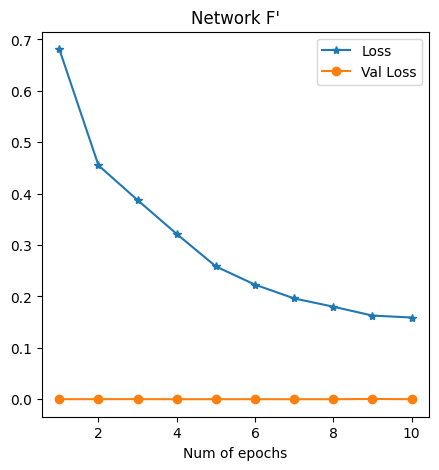

Epsilon: 0	Test Accuracy = 9271 / 10000 = 0.9271
Epsilon: 0.007	Test Accuracy = 9322 / 10000 = 0.9322
Epsilon: 0.01	Test Accuracy = 9266 / 10000 = 0.9266
Epsilon: 0.02	Test Accuracy = 9294 / 10000 = 0.9294
Epsilon: 0.03	Test Accuracy = 9263 / 10000 = 0.9263
Epsilon: 0.05	Test Accuracy = 9250 / 10000 = 0.925
Epsilon: 0.1	Test Accuracy = 9203 / 10000 = 0.9203
Epsilon: 0.2	Test Accuracy = 9154 / 10000 = 0.9154
Epsilon: 0.3	Test Accuracy = 9113 / 10000 = 0.9113


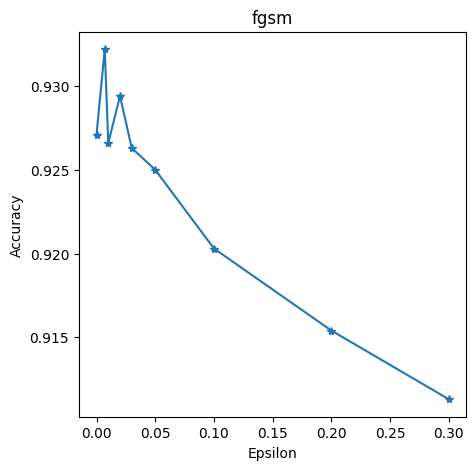

Epsilon: 0	Test Accuracy = 9274 / 10000 = 0.9274
Epsilon: 0.007	Test Accuracy = 9293 / 10000 = 0.9293
Epsilon: 0.01	Test Accuracy = 9286 / 10000 = 0.9286
Epsilon: 0.02	Test Accuracy = 9277 / 10000 = 0.9277
Epsilon: 0.03	Test Accuracy = 9256 / 10000 = 0.9256
Epsilon: 0.05	Test Accuracy = 9272 / 10000 = 0.9272
Epsilon: 0.1	Test Accuracy = 9213 / 10000 = 0.9213
Epsilon: 0.2	Test Accuracy = 9165 / 10000 = 0.9165
Epsilon: 0.3	Test Accuracy = 9118 / 10000 = 0.9118


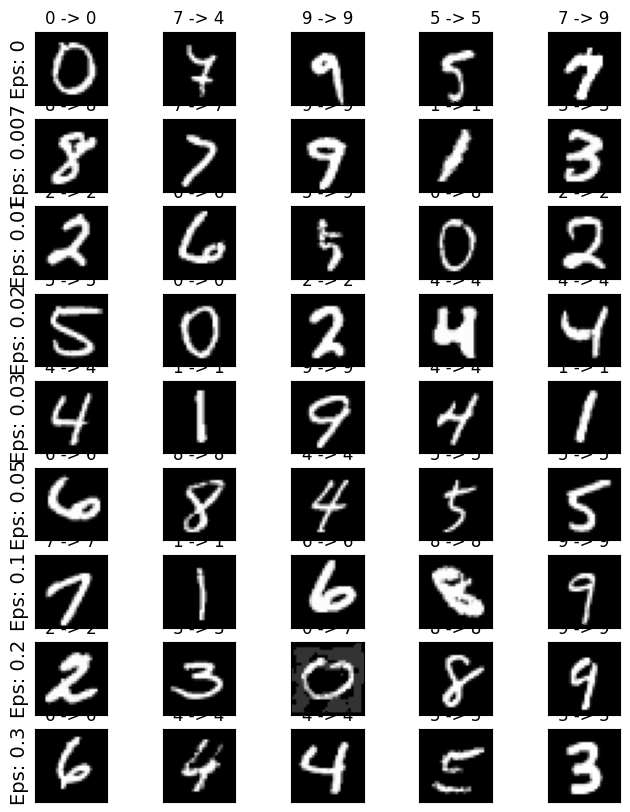

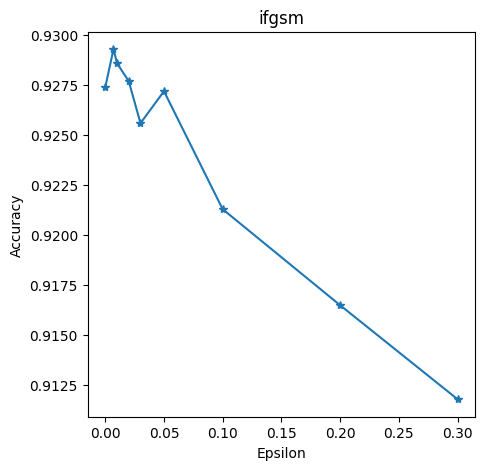

Epsilon: 0	Test Accuracy = 9297 / 10000 = 0.9297
Epsilon: 0.007	Test Accuracy = 9295 / 10000 = 0.9295
Epsilon: 0.01	Test Accuracy = 9316 / 10000 = 0.9316
Epsilon: 0.02	Test Accuracy = 9307 / 10000 = 0.9307
Epsilon: 0.03	Test Accuracy = 9262 / 10000 = 0.9262
Epsilon: 0.05	Test Accuracy = 9234 / 10000 = 0.9234
Epsilon: 0.1	Test Accuracy = 9202 / 10000 = 0.9202
Epsilon: 0.2	Test Accuracy = 9165 / 10000 = 0.9165
Epsilon: 0.3	Test Accuracy = 9099 / 10000 = 0.9099


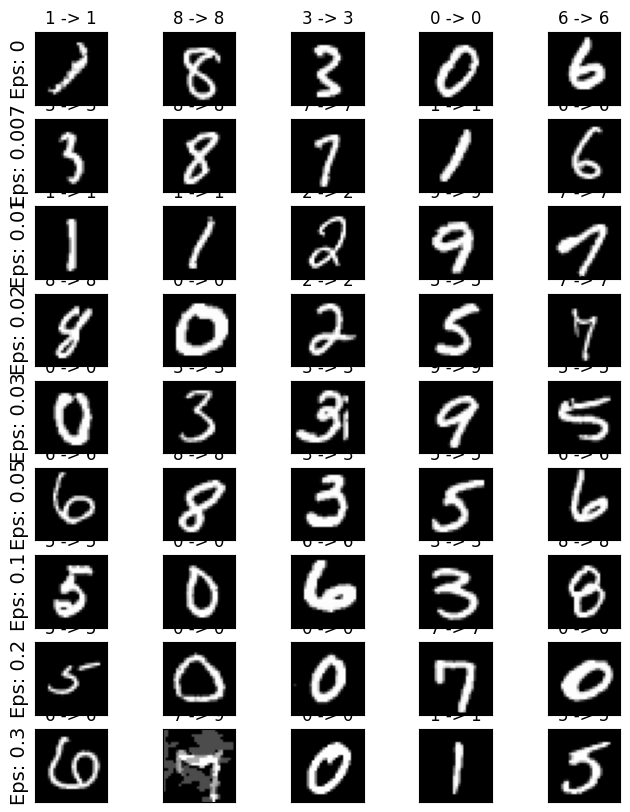

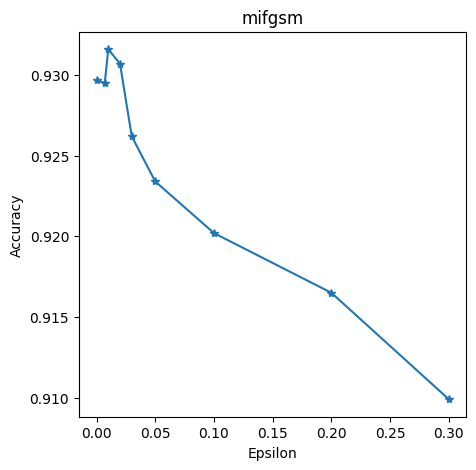

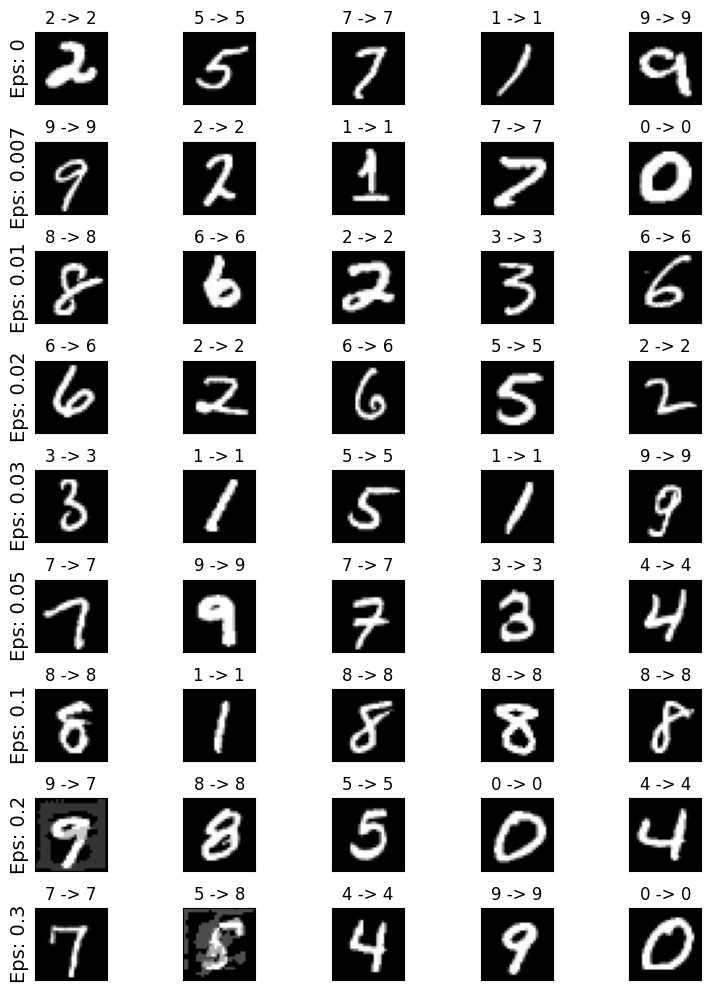

In [ ]:
Temp=100
epochs=10
epsilons=[0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons)